# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [24]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [26]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path='lectures.txt', data_format='vowpal_wabbit',
                                        target_folder='lectures_batches', batch_size=250)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [27]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model = artm.ARTM(num_topics=T, topic_names=topic_names, num_processors=4, class_ids={'text':1, 'author':1},
                  reuse_theta=True, cache_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [28]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model.initialize(dictionary=dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [32]:
# Ваш код
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod1', class_id='text', num_tokens=15))
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod2', class_id='author', num_tokens=15))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [33]:
# Ваш код
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, class_ids='text', dictionary='dictionary', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [34]:
# Ваш код
model.num_document_passes = 1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [35]:
# Ваш код
topic_names_cleared = list(topic_names).remove('bcg')
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, class_ids='text', dictionary='dictionary',
                                                       topic_names=topic_names_cleared))

Выполните еще 15 проходов по коллекции.

In [36]:
# Ваш код
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [37]:
# Ваш код
tokens = model.score_tracker['top_tokens_score_mod1'].last_tokens
for topic_name in model.topic_names:
    print topic_name + ': ',
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  церковь русь власть средневековый император святой сага князь папа александр византийский римский король церковный рим
sbj1:  планета земля атмосфера солнце солнечный белый карлик газ вода вокруг образовываться поверхность спутник океан радиус
sbj2:  система трудность двигаться частота точность относительность самка тест час самец часы поведение задание цикл стандарт
sbj3:  культура понятие культурный восприятие сознание феномен личность ощущение воспринимать чувство переживание этика мария лосев повлиять
sbj4:  право правовой юрист римский юридический должник собственность обязательство владение собственник исполнение имущество договор кредитор искусство
sbj5:  материал структура свет свойство молекула атом углерод полимер оптический поверхность применение кристалл электронный алмаз углеродный
sbj6:  литература фильм книга литературный автор кино произведение жанр кинематограф герой тема театр анекдот написать читатель
sbj7:  смерть ритуал государь обряд правитель конвент терро

In [38]:
authors = model.score_tracker['top_tokens_score_mod2'].last_tokens
for topic_name in model.topic_names:
    print topic_name + ': ',
    for author in authors[topic_name]:    
        print author,
    print

sbj0:  Александр_Марей Фёдор_Успенский Павел_Уваров Татьяна_Бобровникова Алексей_Юдин Игорь_Данилевский Ольга_Вайнштейн Елена_Уханова Ольга_Брилева Владимир_Петрухин Григорий_Бондаренко Елена_Браун Ольга_Тогоева Екатерина_Болтунова Олег_Воскобойников
sbj1:  Сергей_Попов Зоригто_Намсараев Валерий_Сулейманов Дмитрий_Титов Татьяна_Смоктунович Николай_Дронин Кирилл_Еськов Александр_Марков Роман_Рафиков Александр_Слободкин Елизавета_Ривкина Сергей_Писарев Наталья_Новикова Андрей_Глазовский Дмитрий_Вибе
sbj2:  Елена_Брызгалина Александр_Поддьяков Владимир_Мележик Михаил_Пантелеев Эмиль_Ахмедов Виталий_Пальчиков Антон_Суворов Михаил_Фейгельман Василий_Климов Даниэль_Сельва Владимир_Редько Алексей_Желтиков Юджин_Ползик Илья_Щуров Татьяна_Клячко
sbj3:  Виталий_Куренной Константин_Анохин Михаил_Соколов Александр_Гофман Пётр_Турчин Алексей_Руткевич Владимир_Миронов Сергей_Арутюнов Кирилл_Разлогов Николай_Плотников Андрей_Лукашов Ирина_Савельева Александр_Доброхотов Павел_Степанцов Александр_Кисло

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [44]:
sbj_topic_labels = []   # запишите названия тем в список
for topic_name in model.topic_names[:29]:
    sbj_topic_labels.append(tokens[topic_name][0])

topic_labels = sbj_topic_labels + [u"Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [45]:
model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model.get_theta()
print('Theta shape: %s' % str(theta.shape))
phi_a = model.get_phi(class_ids='author')
print('Phi_a shape: %s' % str(phi_a.shape))

Theta shape: (30, 1728)
Phi_a shape: (539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

In [47]:
# Ваш код
theta.iloc[:,:100]


,http://postnauka.ru/video/2530,http://postnauka.ru/video/25304,http://postnauka.ru/video/25307,http://postnauka.ru/video/2531,http://postnauka.ru/video/25312,http://postnauka.ru/video/25318,http://postnauka.ru/video/2532,http://postnauka.ru/video/25321,http://postnauka.ru/video/25326,http://postnauka.ru/video/2541,...,http://postnauka.ru/video/27934,http://postnauka.ru/video/27936,http://postnauka.ru/video/27938,http://postnauka.ru/video/27942,http://postnauka.ru/video/27944,http://postnauka.ru/video/27946,http://postnauka.ru/video/27948,http://postnauka.ru/video/27955,http://postnauka.ru/video/27957,http://postnauka.ru/video/27960
sbj0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.292735e-02,0.000000e+00,0.000000e+00,4.971480e-14,0.000000e+00,...,1.065750e-01,0.000000e+00,0.000000e+00,8.123832e-11,6.292325e-02,0.000000e+00,5.332906e-16,2.645967e-02,1.935201e-10,0.000000e+00
sbj1,0.000000,8.527493e-13,6.077737e-04,0.100623,1.898195e-01,6.308992e-03,1.577541e-02,1.849379e-02,4.777776e-16,0.000000e+00,...,1.333562e-02,0.000000e+00,8.230281e-02,0.000000e+00,1.162252e-15,1.229509e-03,2.807974e-04,3.654998e-15,1.486531e-02,1.776576e-02
sbj2,0.000000,1.026660e-02,3.588686e-03,0.000000,0.000000e+00,0.000000e+00,7.174581e-10,0.000000e+00,1.040750e-02,0.000000e+00,...,4.326089e-08,0.000000e+00,7.745176e-12,2.069583e-04,1.605177e-04,0.000000e+00,1.700392e-14,4.607070e-04,0.000000e+00,7.402297e-03
sbj3,0.068775,2.397808e-04,0.000000e+00,0.000000,7.029600e-07,1.809722e-02,1.368301e-03,2.112192e-04,0.000000e+00,0.000000e+00,...,4.912035e-07,1.559890e-02,1.024280e-01,7.740474e-03,8.720956e-03,2.097802e-02,5.524025e-02,0.000000e+00,0.000000e+00,0.000000e+00
sbj4,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.636868e-03,0.000000e+00,1.207362e-12,7.383841e-16,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,3.342276e-15,3.862611e-03,4.319469e-03,2.348971e-03,0.000000e+00,0.000000e+00,0.000000e+00
sbj5,0.000000,3.901849e-04,0.000000e+00,0.000000,1.367028e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.735213e-09,5.603755e-04,5.038763e-07,3.302813e-04,7.833169e-14,0.000000e+00,6.103807e-07,4.291555e-04,0.000000e+00
sbj6,0.055521,3.324589e-03,2.007202e-07,0.000000,0.000000e+00,2.317039e-02,0.000000e+00,0.000000e+00,0.000000e+00,3.972337e-10,...,4.374261e-08,5.976116e-02,6.585587e-06,1.463669e-09,9.011588e-03,2.486238e-06,7.349944e-03,7.948242e-06,0.000000e+00,0.000000e+00
sbj7,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,4.180097e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.043244e-03,5.181883e-16,4.456103e-06,2.495702e-03,0.000000e+00,0.000000e+00,2.715333e-08,4.271828e-03,0.000000e+00,0.000000e+00
sbj8,0.030909,0.000000e+00,1.587513e-16,0.250000,3.001109e-02,8.673455e-04,3.061327e-13,4.963962e-10,1.291477e-10,0.000000e+00,...,6.023421e-12,1.725874e-06,1.747571e-07,7.691619e-03,0.000000e+00,0.000000e+00,2.903576e-06,3.745196e-15,1.865726e-01,2.906973e-03
sbj9,0.024843,2.686882e-11,6.255697e-13,0.000000,2.507435e-13,6.208475e-02,2.324156e-02,3.550430e-05,2.261494e-02,0.000000e+00,...,0.000000e+00,7.716628e-08,5.517801e-07,1.325856e-14,0.000000e+00,0.000000e+00,0.000000e+00,4.859861e-09,1.368834e-13,2.343564e-08


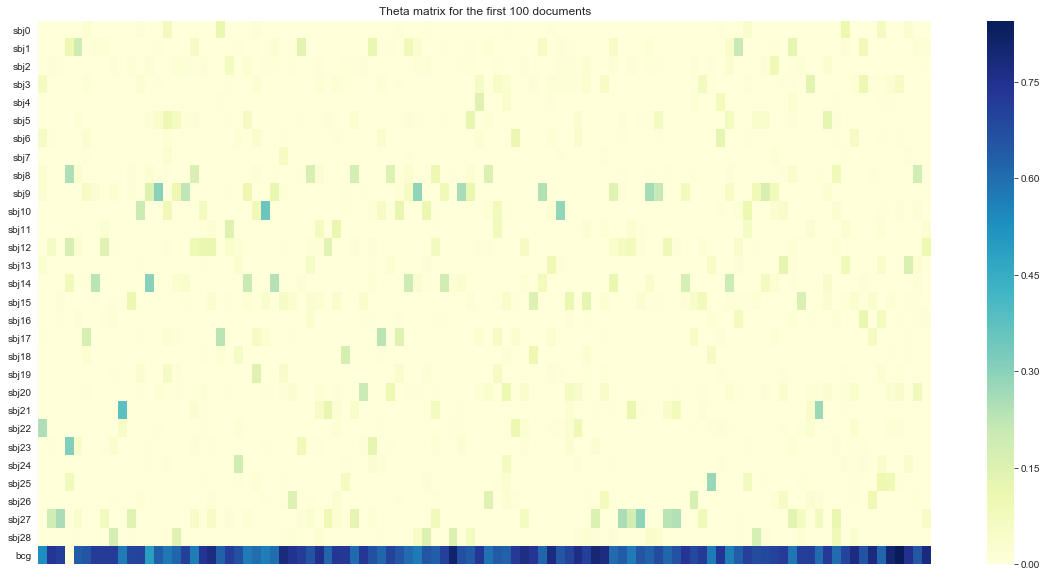

In [48]:

plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
sns.heatmap(theta.iloc[:,:100], cmap='YlGnBu', xticklabels=False)
plt.show();

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [49]:
# Ваш код
prob_theme_data = [np.sum(theta.iloc[i]) for i in range(theta.shape[0])]
prob_theme_data_normed = prob_theme_data / np.sum(prob_theme_data)
prob_theme = pd.DataFrame(data=prob_theme_data_normed, index=topic_labels, columns=['prob'])
prob_theme

,prob
церковь,0.011269
планета,0.011484
система,0.007267
культура,0.017399
право,0.007630
материал,0.012405
литература,0.007591
смерть,0.003884
химический,0.015665
частица,0.021333


In [50]:
prob_theme_max = prob_theme
prob_theme_min = prob_theme

print('Max 5 probabilities:')
for i in range(5):
    max_value = prob_theme_max.max()[0]
    print(prob_theme_max[prob_theme_max.values == max_value].index[0])
    prob_theme_max = prob_theme_max[prob_theme_max.values != max_value]

print('\nMin 3 probabilities:')
for i in range(3):
    min_value = prob_theme_min.min()[0]
    print(prob_theme_min[prob_theme_min.values == min_value].index[0])
    prob_theme_min = prob_theme_min[prob_theme_min.values != min_value]

Max 5 probabilities:
Фоновая тема
клетка
частица
культура
звезда

Min 3 probabilities:
смерть
раса
революция


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

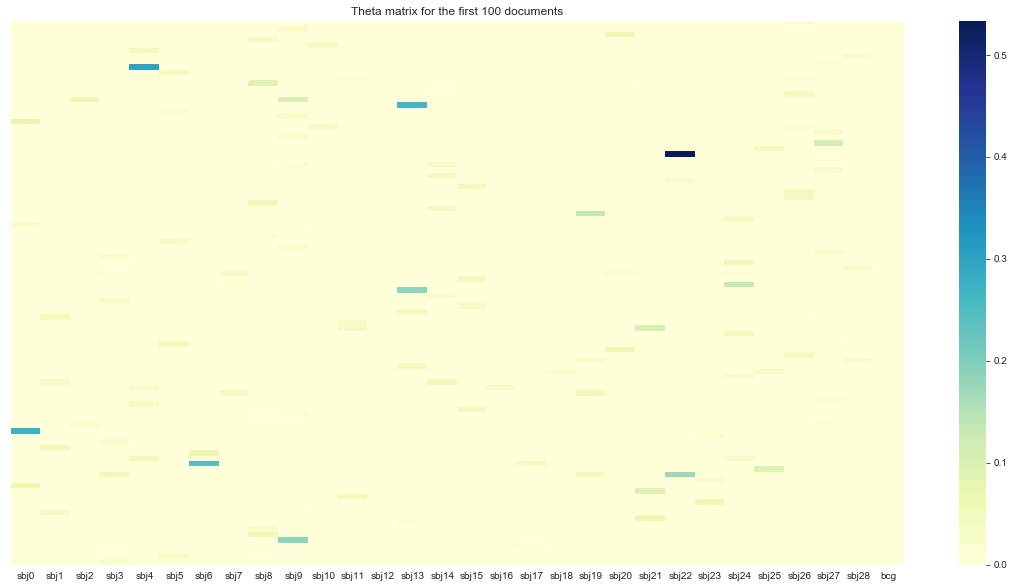

In [51]:
# Ваш код
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
sns.heatmap(phi_a.iloc[:100], cmap='YlGnBu', yticklabels=False)
plt.show();

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [52]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Ярослав_Исполатов,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.014897,0.000000e+00,0.000000e+00,0.0
Сергей_Демокритов,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.032831,...,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
Руслан_Смелянский,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.061120,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
Александр_Апт,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.041209,0.000000,...,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
Людмила_Новикова,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
Александр_Парфенов,0.000000,0.000000e+00,0.000000e+00,0.000000,0.046394,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
Джеффри_Шнапп,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,5.900586e-16,0.0,0.000000,0.000000,0.000000,0.000000e+00,2.501006e-02,0.0
Дмитрий_Чудаков,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,1.701483e-02,0.000000e+00,0.0
Дмитрий_Дождев,0.000000,0.000000e+00,0.000000e+00,0.000000,0.301561,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
Владимир_Шалаев,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.048328,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0


In [53]:
for i in range(phi_a.shape[0]):
    num_valuble_topics = 0
    for val in phi_a.iloc[i]:
        if val > 0.01:
            num_valuble_topics += 1
    if num_valuble_topics >= 3:
        print(i),
        print(phi_a.index[i])

46 Ольга_Артёмова
83 Михаил_Соколов
129 Шринивас_Шридхар
131 Александр_Филиппов
133 Михаил_Маяцкий
194 Михаил_Алексеевский
290 Татьяна_Ребеко
414 Александра_Архипова
444 Павел_Нерлер_(Полян)
471 Ольга_Вайнштейн


In [54]:
print(phi_a.iloc[184])

sbj0     0.000000
sbj1     0.000000
sbj2     0.094983
sbj3     0.000000
sbj4     0.000000
sbj5     0.000000
sbj6     0.000000
sbj7     0.005147
sbj8     0.000000
sbj9     0.000000
sbj10    0.000000
sbj11    0.000000
sbj12    0.000000
sbj13    0.000000
sbj14    0.000000
sbj15    0.000000
sbj16    0.000000
sbj17    0.000000
sbj18    0.000000
sbj19    0.000000
sbj20    0.000000
sbj21    0.039125
sbj22    0.000000
sbj23    0.000000
sbj24    0.000000
sbj25    0.000000
sbj26    0.000000
sbj27    0.000000
sbj28    0.000000
bcg      0.000000
Name: Елена_Брызгалина, dtype: float32


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [57]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [58]:
# Ваш код
prob_theme_author = np.empty(phi_a.shape)
for i in range(prob_theme_author.shape[0]):
    for j in range(prob_theme_author.shape[1]):
        prob_theme_author[i,j] = phi_a.iloc[i,j] * prob_theme.iloc[j,:] / np.sum(phi_a.iloc[i,:] * prob_theme.prob.values)

In [59]:
similarities = pairwise_distances(prob_theme_author, metric='cosine')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(similarities)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

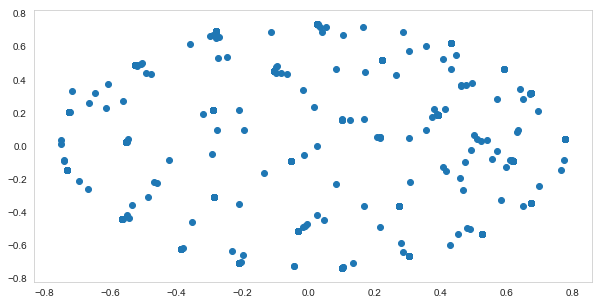

In [60]:
# Ваш код
plt.figure(figsize=(10,5))
plt.scatter(pos[:,0], pos[:,1])
plt.show();


Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

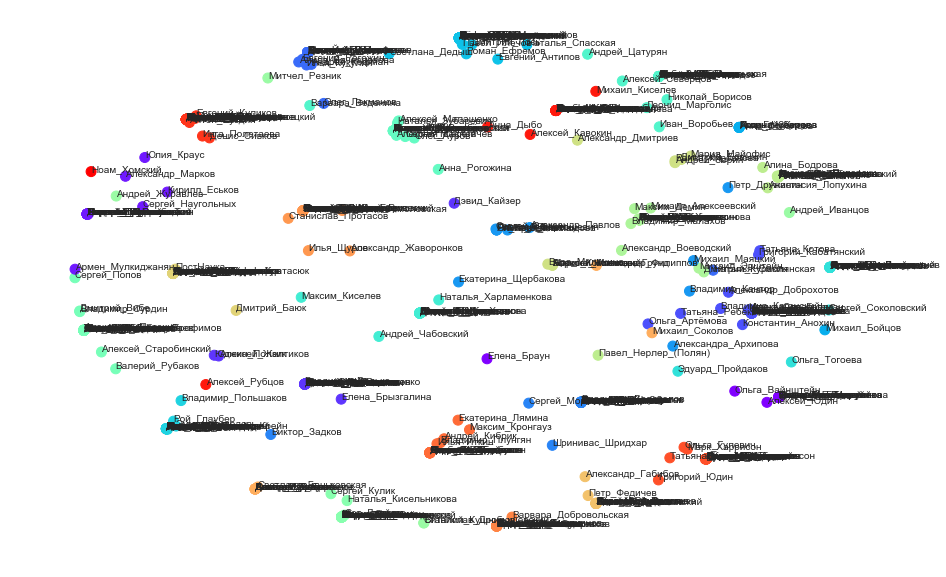

In [62]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
max_theme_prob_for_colors = [np.argmax(author) for author in prob_theme_author]
plt.figure(figsize=(15,10))
plt.axis('off')
plt.scatter(pos[:,0], pos[:,1], s=100, c=colors[max_theme_prob_for_colors])
for i, author in enumerate(phi_a.index):
        plt.annotate(author, pos[i])
plt.savefig('authors_map.pdf', dpi=200, format='pdf')
plt.show();

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [63]:
# Ваш код
prob_doc_theme = theta.values / np.array([np.sum(theme) for theme in theta.values])[:, np.newaxis]
prob_doc_theme_sorted_indices = prob_doc_theme.argsort(axis=1)[:,::-1]
prob_doc_theme_sorted_indices

array([[1192,  757,  687, ..., 1356,  769,    0],
       [1207, 1070, 1150, ...,  516,  515,    0],
       [ 563, 1069,  503, ..., 1272, 1273,    0],
       ...,
       [1142, 1237, 1076, ...,  912,  908,    0],
       [ 148,  848,  594, ...,  702,  701,    0],
       [ 339,  324, 1306, ..., 1076, 1147, 1455]], dtype=int64)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [64]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [65]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [66]:
# Ваш код
# Ваш код
for i, theme in enumerate(topic_labels):
    display(HTML("<h3>%s</h3>" % theme))
    for j in range(10):
        print(tokens[model.topic_names[i]][j]),
    print('')
    for k in range(10):
        print(theta.columns[prob_doc_theme_sorted_indices[i,k]])

церковь русь власть средневековый император святой сага князь папа александр 
http://postnauka.ru/video/9299
http://postnauka.ru/video/3348
http://postnauka.ru/video/24034
http://postnauka.ru/video/9968
http://postnauka.ru/video/24039
http://postnauka.ru/video/24030
http://postnauka.ru/video/28942
http://postnauka.ru/video/23472
http://postnauka.ru/video/50350
http://postnauka.ru/video/31677


планета земля атмосфера солнце солнечный белый карлик газ вода вокруг 
http://postnauka.ru/video/9835
http://postnauka.ru/video/5883
http://postnauka.ru/video/7731
http://postnauka.ru/video/53693
http://postnauka.ru/video/24245
http://postnauka.ru/video/32889
http://postnauka.ru/video/31695
http://postnauka.ru/video/9690
http://postnauka.ru/video/13098
http://postnauka.ru/video/49261


система трудность двигаться частота точность относительность самка тест час самец 
http://postnauka.ru/video/19509
http://postnauka.ru/video/5882
http://postnauka.ru/video/1856
http://postnauka.ru/video/51174
http://postnauka.ru/video/34426
http://postnauka.ru/video/52553
http://postnauka.ru/video/50347
http://postnauka.ru/video/52548
http://postnauka.ru/video/37982
http://postnauka.ru/video/41348


культура понятие культурный восприятие сознание феномен личность ощущение воспринимать чувство 
http://postnauka.ru/video/11034
http://postnauka.ru/video/7169
http://postnauka.ru/video/3405
http://postnauka.ru/video/7770
http://postnauka.ru/video/5517
http://postnauka.ru/video/7549
http://postnauka.ru/video/5180
http://postnauka.ru/video/5891
http://postnauka.ru/video/11246
http://postnauka.ru/video/8623


право правовой юрист римский юридический должник собственность обязательство владение собственник 
http://postnauka.ru/video/17913
http://postnauka.ru/video/13042
http://postnauka.ru/video/31688
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/49455
http://postnauka.ru/video/42221
http://postnauka.ru/video/16822
http://postnauka.ru/video/31666
http://postnauka.ru/video/17825


материал структура свет свойство молекула атом углерод полимер оптический поверхность 
http://postnauka.ru/video/13544
http://postnauka.ru/video/10379
http://postnauka.ru/video/9144
http://postnauka.ru/video/12373
http://postnauka.ru/video/12375
http://postnauka.ru/video/12974
http://postnauka.ru/video/31182
http://postnauka.ru/video/11246
http://postnauka.ru/video/41686
http://postnauka.ru/video/36187


литература фильм книга литературный автор кино произведение жанр кинематограф герой 
http://postnauka.ru/video/24279
http://postnauka.ru/video/39723
http://postnauka.ru/video/10759
http://postnauka.ru/video/38510
http://postnauka.ru/video/13541
http://postnauka.ru/video/23470
http://postnauka.ru/video/57127
http://postnauka.ru/video/52416
http://postnauka.ru/video/20799
http://postnauka.ru/video/47204


смерть ритуал государь обряд правитель конвент террор монтаньяр баратынский диктатура 
http://postnauka.ru/video/1893
http://postnauka.ru/video/1899
http://postnauka.ru/video/34963
http://postnauka.ru/video/37958
http://postnauka.ru/video/48480
http://postnauka.ru/video/32882
http://postnauka.ru/video/37992
http://postnauka.ru/video/50656
http://postnauka.ru/video/21660
http://postnauka.ru/video/51331


химический соединение вещество реакция химия давление органический водород металл синтез 
http://postnauka.ru/video/11646
http://postnauka.ru/video/13151
http://postnauka.ru/video/8953
http://postnauka.ru/video/13700
http://postnauka.ru/video/7363
http://postnauka.ru/video/11023
http://postnauka.ru/video/9144
http://postnauka.ru/video/9861
http://postnauka.ru/video/12373
http://postnauka.ru/video/11630


частица энергия квантовый поле физика взаимодействие электрон кварк теория симметрия 
http://postnauka.ru/video/2945
http://postnauka.ru/video/13043
http://postnauka.ru/video/18870
http://postnauka.ru/video/18873
http://postnauka.ru/video/14283
http://postnauka.ru/video/22760
http://postnauka.ru/video/13151
http://postnauka.ru/video/7311
http://postnauka.ru/video/7753
http://postnauka.ru/video/47826


война россия советский русский власть российский германия мировой реформа историк 
http://postnauka.ru/video/19574
http://postnauka.ru/video/35041
http://postnauka.ru/video/25906
http://postnauka.ru/video/31183
http://postnauka.ru/video/46939
http://postnauka.ru/video/29992
http://postnauka.ru/video/36246
http://postnauka.ru/video/42423
http://postnauka.ru/video/51180
http://postnauka.ru/video/42809


ребенок женщина семья мужчина возраст взрослый сон мать родитель старение 
http://postnauka.ru/video/6377
http://postnauka.ru/video/22892
http://postnauka.ru/video/10753
http://postnauka.ru/video/30678
http://postnauka.ru/video/11361
http://postnauka.ru/video/59638
http://postnauka.ru/video/3605
http://postnauka.ru/video/31220
http://postnauka.ru/video/60527
http://postnauka.ru/video/18613


мозг растение ткань опухоль орган озеро сердце мышца иммунный птица 
http://postnauka.ru/video/16821
http://postnauka.ru/video/5390
http://postnauka.ru/video/19436
http://postnauka.ru/video/23172
http://postnauka.ru/video/33763
http://postnauka.ru/video/46562
http://postnauka.ru/video/15044
http://postnauka.ru/video/36350
http://postnauka.ru/video/51169
http://postnauka.ru/video/51501


территория христианский империя восток народ древний письменность век христианство памятник 
http://postnauka.ru/video/53171
http://postnauka.ru/video/6377
http://postnauka.ru/video/2527
http://postnauka.ru/video/5891
http://postnauka.ru/video/10751
http://postnauka.ru/video/7785
http://postnauka.ru/video/50071
http://postnauka.ru/video/59201
http://postnauka.ru/video/58742
http://postnauka.ru/video/3387


звезда галактика масса черный вселенная дыра излучение скорость волна объект 
http://postnauka.ru/video/6673
http://postnauka.ru/video/7067
http://postnauka.ru/video/31193
http://postnauka.ru/video/17780
http://postnauka.ru/video/2971
http://postnauka.ru/video/48109
http://postnauka.ru/video/30015
http://postnauka.ru/video/45644
http://postnauka.ru/video/57338
http://postnauka.ru/video/23506


задача информация память решение данные компьютер метод психология мышление анализ 
http://postnauka.ru/video/19509
http://postnauka.ru/video/7713
http://postnauka.ru/video/24451
http://postnauka.ru/video/9727
http://postnauka.ru/video/24182
http://postnauka.ru/video/56052
http://postnauka.ru/video/57336
http://postnauka.ru/video/19577
http://postnauka.ru/video/23763
http://postnauka.ru/video/53415


раса африка остров америка станислав южный монголоид дробышевский нос индия 
http://postnauka.ru/video/31707
http://postnauka.ru/video/17397
http://postnauka.ru/video/49262
http://postnauka.ru/video/37732
http://postnauka.ru/video/32898
http://postnauka.ru/video/35150
http://postnauka.ru/video/42707
http://postnauka.ru/video/42735
http://postnauka.ru/video/40880
http://postnauka.ru/video/36253


политический философия государство общество философский философ партия идеология платон мысль 
http://postnauka.ru/video/3418
http://postnauka.ru/video/12738
http://postnauka.ru/video/8623
http://postnauka.ru/video/12371
http://postnauka.ru/video/7764
http://postnauka.ru/video/32906
http://postnauka.ru/video/3405
http://postnauka.ru/video/2526
http://postnauka.ru/video/37965
http://postnauka.ru/video/53044


слово текст русский словарь предложение значение глагол корпус перевод категория 
http://postnauka.ru/video/36272
http://postnauka.ru/video/47548
http://postnauka.ru/video/48960
http://postnauka.ru/video/1898
http://postnauka.ru/video/51499
http://postnauka.ru/video/2946
http://postnauka.ru/video/56616
http://postnauka.ru/video/30017
http://postnauka.ru/video/57524
http://postnauka.ru/video/2961


революция французский франция король костюм нация национальный свобода аргумент актер 
http://postnauka.ru/video/5396
http://postnauka.ru/video/48492
http://postnauka.ru/video/3599
http://postnauka.ru/video/47823
http://postnauka.ru/video/43843
http://postnauka.ru/video/40004
http://postnauka.ru/video/22079
http://postnauka.ru/video/53577
http://postnauka.ru/video/28944
http://postnauka.ru/video/45548


город сеть робот городской технология интернет компания пользователь музей медиа 
http://postnauka.ru/video/12172
http://postnauka.ru/video/13742
http://postnauka.ru/video/12515
http://postnauka.ru/video/11634
http://postnauka.ru/video/9998
http://postnauka.ru/video/7514
http://postnauka.ru/video/7068
http://postnauka.ru/video/17604
http://postnauka.ru/video/47301
http://postnauka.ru/video/8313


болезнь заболевание пациент лечение врач медицина боль препарат медицинский операция 
http://postnauka.ru/video/12974
http://postnauka.ru/video/2541
http://postnauka.ru/video/7260
http://postnauka.ru/video/11630
http://postnauka.ru/video/54325
http://postnauka.ru/video/7713
http://postnauka.ru/video/49206
http://postnauka.ru/video/9727
http://postnauka.ru/video/45961
http://postnauka.ru/video/27925


социальный знание социология социологический дисциплина познание социолог повседневный научный виктор 
http://postnauka.ru/video/6380
http://postnauka.ru/video/10783
http://postnauka.ru/video/51350
http://postnauka.ru/video/5517
http://postnauka.ru/video/434
http://postnauka.ru/video/12083
http://postnauka.ru/video/17491
http://postnauka.ru/video/20720
http://postnauka.ru/video/23361
http://postnauka.ru/video/2530


микроорганизм матрица алгоритм интеллект эмоция схема вычислительный эмоциональный искусственный микроб 
http://postnauka.ru/video/2531
http://postnauka.ru/video/5883
http://postnauka.ru/video/31671
http://postnauka.ru/video/52738
http://postnauka.ru/video/42416
http://postnauka.ru/video/3635
http://postnauka.ru/video/34964
http://postnauka.ru/video/8953
http://postnauka.ru/video/3420
http://postnauka.ru/video/49437


бог миф царь греческий мифология египет душа море грек представление 
http://postnauka.ru/video/10779
http://postnauka.ru/video/12156
http://postnauka.ru/video/5876
http://postnauka.ru/video/9556
http://postnauka.ru/video/9992
http://postnauka.ru/video/12527
http://postnauka.ru/video/7351
http://postnauka.ru/video/10477
http://postnauka.ru/video/7065
http://postnauka.ru/video/7785


язык лингвист языковой гласный английский согласный лингвистика говор лингвистический звук 
http://postnauka.ru/video/13041
http://postnauka.ru/video/7755
http://postnauka.ru/video/10473
http://postnauka.ru/video/8674
http://postnauka.ru/video/9556
http://postnauka.ru/video/7525
http://postnauka.ru/video/10773
http://postnauka.ru/video/48114
http://postnauka.ru/video/8964
http://postnauka.ru/video/27825


страна экономический экономика политика сталин идентичность коллективный кризис праздник принятие 
http://postnauka.ru/video/9389
http://postnauka.ru/video/3605
http://postnauka.ru/video/5882
http://postnauka.ru/video/31684
http://postnauka.ru/video/7770
http://postnauka.ru/video/7781
http://postnauka.ru/video/8632
http://postnauka.ru/video/6758
http://postnauka.ru/video/13152
http://postnauka.ru/video/30601


клетка ген днк белок организм биологический животное генетический молекула нейрон 
http://postnauka.ru/video/7365
http://postnauka.ru/video/10475
http://postnauka.ru/video/5915
http://postnauka.ru/video/11628
http://postnauka.ru/video/19436
http://postnauka.ru/video/5390
http://postnauka.ru/video/10382
http://postnauka.ru/video/9727
http://postnauka.ru/video/7260
http://postnauka.ru/video/10754


температура университет магнитный сверхпроводимость ток сверхпроводник сверхпроводящий железо профессор заимствование 
http://postnauka.ru/video/2973
http://postnauka.ru/video/3603
http://postnauka.ru/video/21125
http://postnauka.ru/video/50340
http://postnauka.ru/video/22314
http://postnauka.ru/video/31198
http://postnauka.ru/video/50699
http://postnauka.ru/video/24473
http://postnauka.ru/video/25326
http://postnauka.ru/video/55756


быть что это который этот как они мочь такой очень 
http://postnauka.ru/video/51365
http://postnauka.ru/video/51184
http://postnauka.ru/video/12376
http://postnauka.ru/video/49851
http://postnauka.ru/video/42436
http://postnauka.ru/video/50706
http://postnauka.ru/video/10750
http://postnauka.ru/video/51178
http://postnauka.ru/video/54668
http://postnauka.ru/video/41678


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 